# Spotify API

In [194]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Data Science/Final Project/spotify-songs.csv')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Song ID
0,000xQL6tZNLJzIrtIgxqSl
1,000xYdQfIZ4pDmBGzQalKU
2,004q4eDxR33ci4f8m4flwl
3,005ojEjmGPAfBptQDTYi5T
4,006pMMCuRo2TFjh8sNGSov
...,...
31117,7zvwxa2s4zIX7y49plhrmo
31118,7zxRMhXxJMQCeDDg0rKAVo
31119,7zxd3J5hMPeLN71VS8vnE4
31120,7zyYmIdjqqiX6kLryb7QBx


In [ ]:
import random
import numpy as np

# list of unique song ID's
songs = np.unique(list(df['Song ID']))

# shuffling the list to make train and test sampling random
random.shuffle(songs)

# dividing songs into 20,000 train and 10,000 test
train_songs = songs[0:20000]
test_songs = songs[20000:30000]
print('Train Set: ' + str(len(train_songs)))
print('Test Set: ' + str(len(test_songs)))

Train Set: 20000
Test Set: 10000


In [ ]:
!pip install spotipy
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

credentials = json.load(open('/content/drive/MyDrive/Colab Notebooks/Business Data Science/Final Project/authorization.json'))
client_id = credentials['client_id']
client_secret = credentials['client_secret']

In [ ]:
import requests
import base64
import json
from secrets import *
from pandas import json_normalize
import time

def scrape_songs(df, songs):
  popularity = []
  artists = []
  album_name = []
  release_date = []
  name = []

  for id in songs:
    playlistUrl = f"https://api.spotify.com/v1/audio-features/" + id
    playlistUrl_pop = f"https://api.spotify.com/v1/tracks/" + id

    headers = {
        "Authorization": "Bearer " + token
    }

    time.sleep(0.1)
    res = requests.get(url=playlistUrl, headers=headers)
    time.sleep(0.1)
    res_pop = requests.get(url=playlistUrl_pop, headers=headers)
    data = json.loads(json.dumps(res.json(), indent=2))
    data_pop = json.loads(json.dumps(res_pop.json(), indent=2))
    df = df.append(pd.json_normalize(data))
    popularity.append(data_pop['popularity'])
    artists.append(data_pop['artists'][0]['name'])
    album_name.append(data_pop['album']['name'])
    release_date.append(data_pop['album']['release_date'])
    name.append(data_pop['name'])

  df['popularity'] = popularity
  df['artists'] = artists
  df['album-name'] = album_name
  df['release-date'] = release_date
  df['id'] = songs
  df['name'] = name
  return df

# Step 1 - Authorization 
url = "https://accounts.spotify.com/api/token"
headers = {}
data = {}

# Encode as Base64
message = f"{client_id}:{client_secret}"
messageBytes = message.encode('ascii')
base64Bytes = base64.b64encode(messageBytes)
base64Message = base64Bytes.decode('ascii')
headers['Authorization'] = f"Basic {base64Message}"
data['grant_type'] = "client_credentials"

r = requests.post(url, headers=headers, data=data)

token = r.json()['access_token']

In [ ]:
# scraping train dataset
df_train = pd.DataFrame()
df_train = scrape_songs(df_train, train_songs)
df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

# scraping test dataset
df_test = pd.DataFrame()
df_test = scrape_songs(df_test, test_songs)
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/test.csv')

# Loading Data

In [195]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Data Science/Final Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Data Science/Final Project/test.csv')

train.dropna(inplace=True)
test.dropna(inplace=True)

combined = train.append(test)
combined.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,popularity,artists,album-name,release-date,name
0,0.535,0.534,2,-6.195,1,0.4290,0.564,0.000003,0.1700,0.217,181.893,audio_features,46GIUbDGTrJ4MDx2BpyFe3,spotify:track:46GIUbDGTrJ4MDx2BpyFe3,https://api.spotify.com/v1/tracks/46GIUbDGTrJ4...,https://api.spotify.com/v1/audio-analysis/46GI...,228507,4,39,Kollegah,Imperator (Deluxe Edition),12/9/16,Aventador
1,0.441,0.110,1,-12.508,1,0.0390,0.824,0.000000,0.0981,0.261,120.205,audio_features,4Eq0F51L7foy3hFvz0zQNp,spotify:track:4Eq0F51L7foy3hFvz0zQNp,https://api.spotify.com/v1/tracks/4Eq0F51L7foy...,https://api.spotify.com/v1/audio-analysis/4Eq0...,265187,4,22,Parker Millsap,The Very Last Day,3/25/16,A Little Fire
2,0.312,0.423,2,-13.788,0,0.1220,0.542,0.000000,0.0994,0.326,81.328,audio_features,7hIMlT6itbXyvjp7HYPzUP,spotify:track:7hIMlT6itbXyvjp7HYPzUP,https://api.spotify.com/v1/tracks/7hIMlT6itbXy...,https://api.spotify.com/v1/audio-analysis/7hIM...,188293,4,53,Özdemir Erdoğan,İkinci Bahar,1987,Küçük Bir Aşk Masalı
3,0.446,0.370,9,-8.447,1,0.0464,0.913,0.000000,0.1260,0.209,108.580,audio_features,4ks6j7JsfJorc1tb4THJo8,spotify:track:4ks6j7JsfJorc1tb4THJo8,https://api.spotify.com/v1/tracks/4ks6j7JsfJor...,https://api.spotify.com/v1/audio-analysis/4ks6...,164129,3,64,Conor Maynard,Covers,8/5/16,Don't Let Me Down
4,0.581,0.354,2,-8.066,1,0.0307,0.483,0.000000,0.0630,0.819,153.939,audio_features,3Ic6UpDYVHS1JgHQC2ghrz,spotify:track:3Ic6UpDYVHS1JgHQC2ghrz,https://api.spotify.com/v1/tracks/3Ic6UpDYVHS1...,https://api.spotify.com/v1/audio-analysis/3Ic6...,276333,4,10,Shota Shimizu,Fire,3/3/17,My Boo (Acoustic ver.)


# Popularity Analysis

## Radar Chart

In [ ]:
combined['release-year'] = combined['release-date'].apply(lambda x: int('19'+x[-2:]) if int(x[-2:]) > 21 else int('20'+x[-2:]))

sorted_df = combined.sort_values('popularity', ascending = False).head(100)
unpopular_df = combined.sort_values('popularity', ascending = True).head(100)

new_songs = combined.loc[combined['release-year'] >= 2000]
old_songs = combined.loc[combined['release-year'] < 2000]

In [ ]:
labels = list(sorted_df[sorted_df.mean().index])
labels_1 = labels[len(labels)-4:len(labels)]
labels = labels[:-4]

labels_1.append(labels.pop(2))
labels_1.append(labels.pop(2))
labels_1.pop(3)

features_popular = sorted_df[labels].mean().tolist()
features_unpopular = unpopular_df[labels].mean().tolist()

features_new = new_songs[labels].mean().tolist()
features_old = old_songs[labels].mean().tolist()

### Popular vs Unpopular Songs

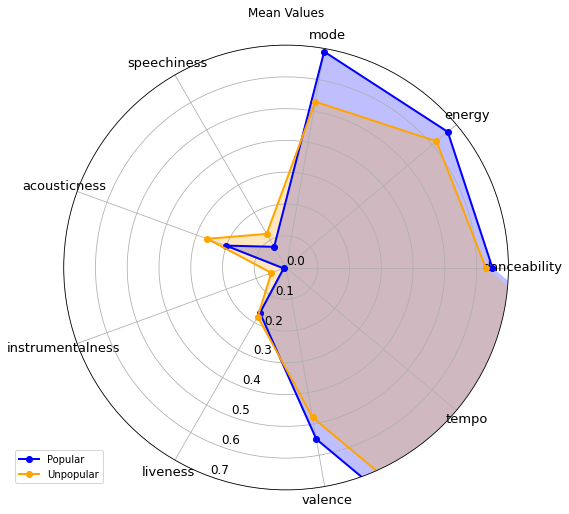

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
fig = plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, features_popular, 'o-', linewidth=2, label = "Popular", color= 'blue')
ax.fill(angles, features_popular, alpha=0.25, facecolor='blue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)

ax.set_rlabel_position(250)
plt.yticks([0, 0.1 , 0.2 , 0.3 , 0.4, 0.5,  0.6, 0.7], ["0.0", "0.1",'0.2', "0.3", "0.4", "0.5", "0.6", '0.7'], size=12)
plt.ylim(0,0.7)

ax.plot(angles, features_unpopular, 'o-', linewidth=2, label = "Unpopular", color= 'orange')
ax.fill(angles, features_unpopular, alpha=0.25, facecolor='orange')
ax.set_title('Mean Values')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

### Songs before and after 2000

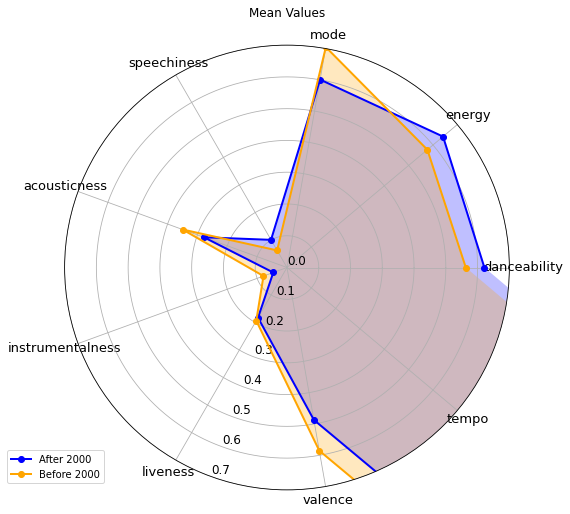

In [ ]:
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
fig = plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, features_new, 'o-', linewidth=2, label = "After 2000", color= 'blue')
ax.fill(angles, features_new, alpha=0.25, facecolor='blue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)

ax.set_rlabel_position(250)
plt.yticks([0, 0.1 , 0.2 , 0.3 , 0.4, 0.5,  0.6, 0.7], ["0.0", "0.1",'0.2', "0.3", "0.4", "0.5", "0.6", '0.7'], size=12)
plt.ylim(0,0.7)

ax.plot(angles, features_old, 'o-', linewidth=2, label = "Before 2000", color= 'orange')
ax.fill(angles, features_old, alpha=0.25, facecolor='orange')
ax.set_title('Mean Values')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

## Feature Distributions

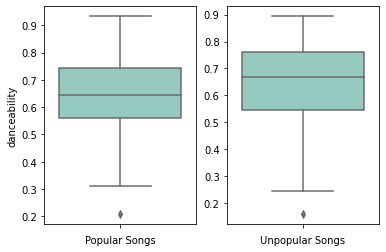

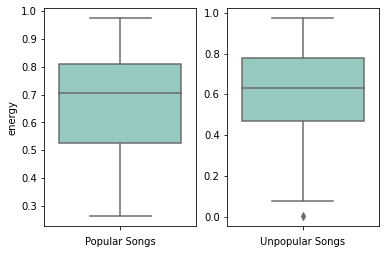

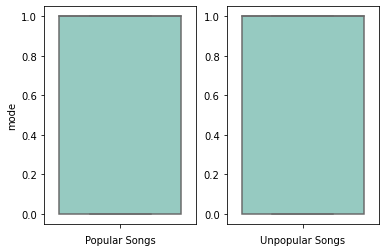

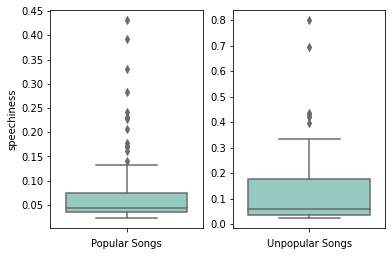

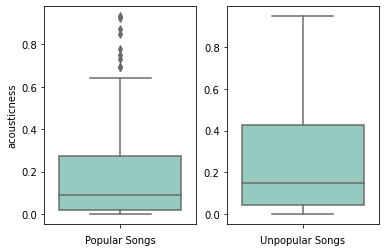

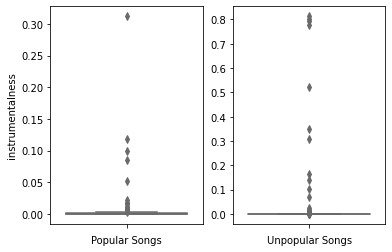

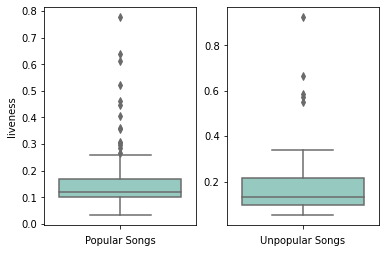

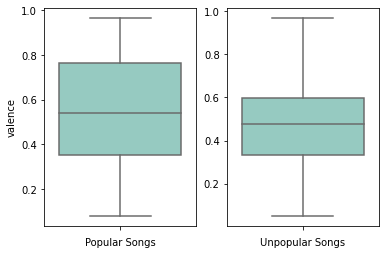

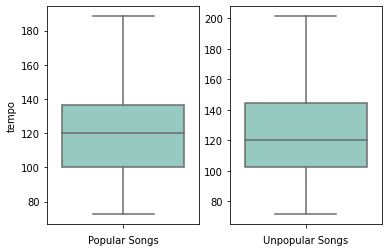

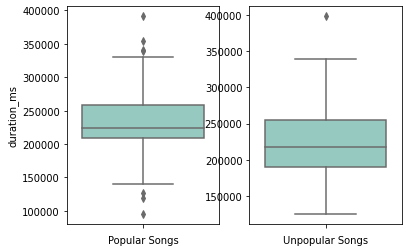

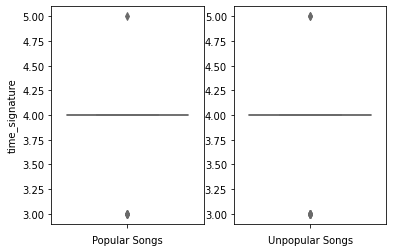

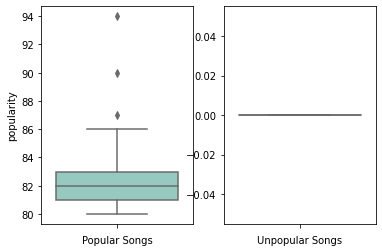

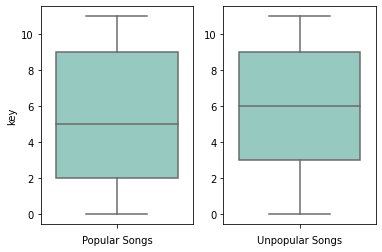

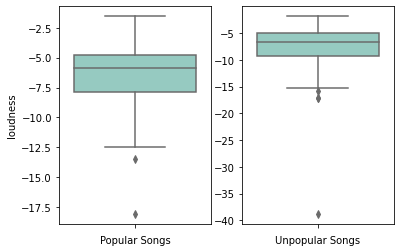

In [ ]:
import seaborn as sns

for i in labels:
  f, axes = plt.subplots(1, 2)
  sns.boxplot(y=i, data=sorted_df, palette="Set3",ax=axes[0]).set(xlabel='Popular Songs', ylabel=i)
  sns.boxplot(y=i, data=unpopular_df, palette="Set3",ax=axes[1]).set(xlabel='Unpopular Songs', ylabel='')
  fig.tight_layout()
  plt.show()

for i in labels_1:
  f, axes = plt.subplots(1, 2)
  sns.boxplot(y=i, data=sorted_df, palette="Set3",ax=axes[0]).set(xlabel='Popular Songs', ylabel=i)
  sns.boxplot(y=i, data=unpopular_df, palette="Set3",ax=axes[1]).set(xlabel='Unpopular Songs', ylabel='')
  fig.tight_layout()
  plt.show()

# Correlation Analysis

## Energy versus Danceability

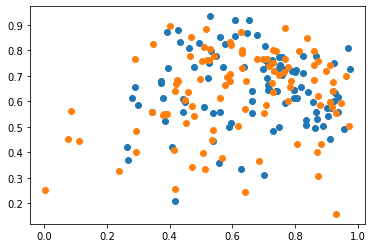

In [ ]:
plt.scatter(sorted_df.energy, sorted_df.danceability)
plt.scatter(unpopular_df.energy, unpopular_df.danceability)

## Valence and Liveliness

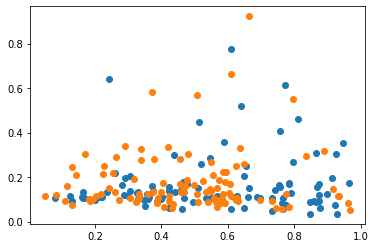

In [ ]:
plt.scatter(sorted_df.valence, sorted_df.liveness)
plt.scatter(unpopular_df.valence, unpopular_df.liveness)

# Most Popular Artists

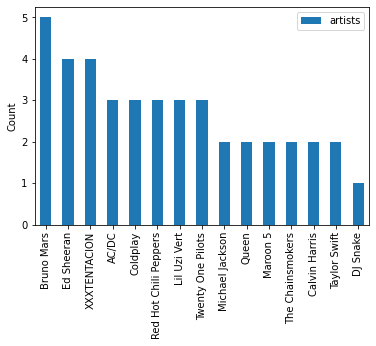

In [ ]:
pd.DataFrame(sorted_df['artists'].value_counts()).head(15).plot.bar(ylabel='Count')

# Lyrics Scraping

In [ ]:
from bs4 import BeautifulSoup
import re
import os
import requests

#function to scrape lyrics from genius
def scrape_lyrics(artistname, songname):
    artistname2 = str(artistname.replace(' ','-')) if ' ' in artistname else str(artistname)
    songname2 = str(songname.replace(' ','-')) if ' ' in songname else str(songname)
    url = 'https://genius.com/'+ artistname2 + '-' + songname2 + '-' + 'lyrics'
    page = requests.get(url)
    html = BeautifulSoup(page.text, 'html.parser')
    lyrics = html.find('div', class_='Lyrics__Container-sc-1ynbvzw-6 lgZgEN')
    if lyrics:
      lyrics = lyrics.get_text()
      #remove identifiers like chorus, verse, etc
      lyrics = re.sub(r'[\(\[].*?[\)\]]', ' ', lyrics)
      #remove empty lines
      lyrics = os.linesep.join([s for s in lyrics.splitlines() if s])         
    return lyrics

lyrics = []
for song in train[11000:12000].iterrows():
  lyrics.append(scrape_lyrics(song[1]['artists'], song[1]['name']))

In [ ]:
temp = train[11000:12000]
temp['lyrics'] = lyrics
temp.to_csv('first-1000.csv')

In [ ]:
songs = songs.replace(to_replace='None', value=None)
songs.dropna(inplace=True)
songs.to_csv('lyrics.csv')

# Preprocesing

In [257]:
from sklearn.utils import resample

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Data Science/Final Project/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Data Science/Final Project/test.csv')

train.dropna(inplace=True)
test.dropna(inplace=True)

train['popularity'] = [1 if i >= 60 else 0 for i in train['popularity']]
test['popularity'] = [1 if i >= 60 else 0 for i in test['popularity']]

y_train = train['popularity']
X_train = train.drop(['type', 'id', 'uri', 'track_href', 'analysis_url', 'artists', 'album-name', 'release-date', 'name'], axis=1)

y_test = test['popularity']
X_test = test.drop(['popularity', 'type', 'id', 'uri', 'track_href', 'analysis_url', 'artists', 'album-name', 'release-date', 'name'], axis=1)

# Separate majority and minority classes
df_majority = X_train[X_train.popularity==0]
df_minority = X_train[X_train.popularity==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=123)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
X_train = df_upsampled.sample(frac=1, random_state=123).reset_index(drop=True)

y_train = X_train.popularity.values
X_train.drop(['popularity'], axis=1, inplace=True)

# Classification Models

## XGB

In [258]:
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

xgb = XGBClassifier(max_depth=15, learning_rate=0.08, booster='gbtree', gamma=0.5, min_child_weight=0.9, reg_alpha=0.01, random_state=1)
xgb.fit(X_train, y_train)

print('Train AUC: ' + str(roc_auc_score(y_train, xgb.predict_proba(X_train)[:, 1], multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, xgb.predict(X_train))))

print('\nTest AUC: ' + str(roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1], multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, xgb.predict(X_test))))

Train AUC: 0.9997727421361757
Train Accuracy: 0.9974041385448342

Test AUC: 0.5927851217385769
Test Accuracy: 0.870291777188329


### Feature Importance

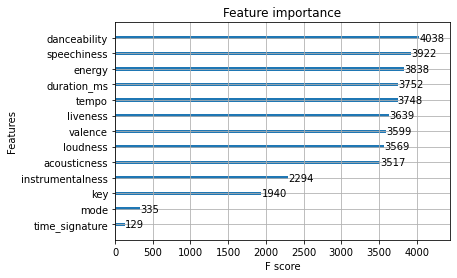

In [198]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(xgb)
pyplot.show()

## Random Forest

In [199]:
from sklearn.ensemble import RandomForestClassifier

rf = make_pipeline(RobustScaler(), RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=10, min_samples_leaf=5, max_features="auto", bootstrap=True, n_jobs=-1, random_state=1))
rf.fit(X_train, y_train)

print('Train AUC: ' + str(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1], multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, rf.predict(X_train))))

print('\nTest AUC: ' + str(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1], multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, rf.predict(X_test))))

Train AUC: 0.9966733307006806
Train Accuracy: 0.9762664095527701

Test AUC: 0.607435733488962
Test Accuracy: 0.8314323607427055


## Ensemble (RF + XGB)

In [200]:
train_pred_proba = (0.5 * xgb.predict_proba(X_train)[:, 1]) + (0.5 * rf.predict_proba(X_train)[:, 1])
train_pred = [1 if i >= 0.5 else 0 for i in train_pred_proba]

test_pred_proba = (0.5 * xgb.predict_proba(X_test)[:, 1]) + (0.5 * rf.predict_proba(X_test)[:, 1])
test_pred = [1 if i >= 0.5 else 0 for i in test_pred_proba]

print('Train AUC: ' + str(roc_auc_score(y_train, train_pred_proba, multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, train_pred)))

print('\nTest AUC: ' + str(roc_auc_score(y_test, test_pred_proba, multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, test_pred)))

Train AUC: 0.9993541522223321
Train Accuracy: 0.9970333011940963

Test AUC: 0.6063291329358226
Test Accuracy: 0.8681697612732096


### Analysis

In [201]:
correct = X_test.loc[test_pred == y_test]
incorrect = X_test.loc[test_pred != y_test]

labels = list(correct[correct.mean().index])
labels = labels[:-2]
labels.pop(2)
labels.pop(2)

features_correct = correct[labels].mean().tolist()
features_incorrect = incorrect[labels].mean().tolist()

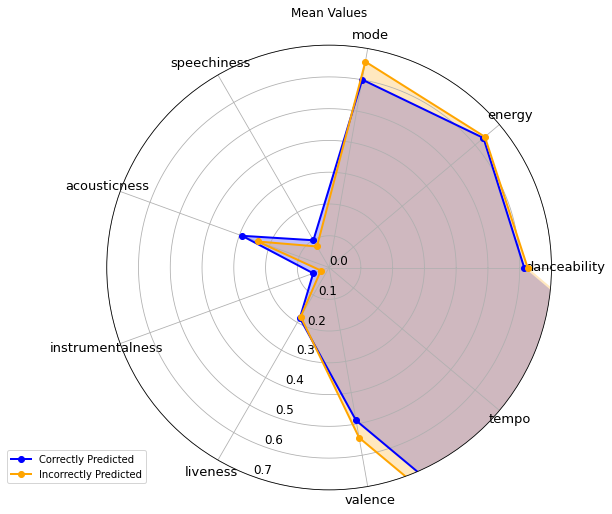

In [202]:
import numpy as np
import matplotlib.pyplot as plt

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
fig = plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, features_correct, 'o-', linewidth=2, label = "Correctly Predicted", color= 'blue')
ax.fill(angles, features_correct, alpha=0.25, facecolor='blue')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)

ax.set_rlabel_position(250)
plt.yticks([0, 0.1 , 0.2 , 0.3 , 0.4, 0.5,  0.6, 0.7], ["0.0", "0.1",'0.2', "0.3", "0.4", "0.5", "0.6", '0.7'], size=12)
plt.ylim(0,0.7)

ax.plot(angles, features_incorrect, 'o-', linewidth=2, label = "Incorrectly Predicted", color= 'orange')
ax.fill(angles, features_incorrect, alpha=0.25, facecolor='orange')
ax.set_title('Mean Values')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))

## Other Models

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(metric='manhattan', n_neighbors=23, weights='distance')
knn = knn.fit(X_train, y_train)

print('Train AUC: ' + str(roc_auc_score(y_train, knn.predict_proba(X_train)[:, 1], multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, knn.predict(X_train))))

print('\nTest AUC: ' + str(roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1], multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, knn.predict(X_test))))

Train AUC: 0.9998923216027594
Train Accuracy: 0.9939451561248999

Test AUC: 0.5202582790926551
Test Accuracy: 0.7617093674939952


In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0)
lr = lr.fit(X_train, y_train)

print('Train AUC: ' + str(roc_auc_score(y_train, lr.predict_proba(X_train)[:, 1], multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, lr.predict(X_train))))

print('\nTest AUC: ' + str(roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1], multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, lr.predict(X_test))))

Train AUC: 0.4888402530765173
Train Accuracy: 0.7810248198558847

Test AUC: 0.4870063698495032
Test Accuracy: 0.7792233787029623


# Additional NLP Features

1.   Hugging Face (Perplexity and NLL)
2.   Genre
3.   Vader Sentiment Score
4.   Topic Modelling

Took a smaller sample of the Dataset (3,000 Songs)


In [259]:
from sklearn import preprocessing

train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Business Data Science/Final Project/topics-genre-sentiment-perplexity-nll.csv')
train.dropna(inplace=True)

train['popularity'] = [1 if i >= 50 else 0 for i in train['popularity']] 

train = train.drop(['type', 'uri', 'track_href', 'analysis_url', 'artists', 'album-name', 'release-date', 'id.1', 'name', 'lyrics'], axis=1)
genre = train['genre']

train['genre'] = preprocessing.LabelEncoder().fit_transform(train['genre'])

# Separate majority and minority classes
df_majority = train[train.popularity==0]
df_minority = train[train.popularity==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=123)

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
df_upsampled = df_upsampled.sample(frac=1, random_state=123).reset_index(drop=True)

y_upsampled = df_upsampled.popularity.values
df_upsampled.drop(['popularity'], axis=1, inplace=True)

In [260]:
df_upsampled

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,perplexity,nll,vader_sentiment,song_length,genre,topic_modelling
0,0.779,0.867,3,-3.704,0,0.0457,0.0491,0.000008,0.1970,0.915,138.858,258040,4,14.980769,13.312875,-0.8632,2356,6,0
1,0.530,0.920,1,-2.912,1,0.0734,0.0255,0.000000,0.1680,0.738,191.977,236250,4,16.528713,13.928768,0.9993,2967,6,1
2,0.516,0.916,7,-7.255,1,0.0644,0.2370,0.000000,0.6360,0.478,102.779,261000,4,7.145505,9.832417,0.9360,696,1,0
3,0.770,0.752,1,-6.468,1,0.1500,0.1360,0.000009,0.1060,0.577,113.203,213348,4,11.635190,12.150461,-0.8135,2383,7,0
4,0.707,0.299,4,-12.468,0,0.0342,0.4430,0.007590,0.0976,0.480,141.269,202693,4,22.775009,15.628318,0.9771,1027,9,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,0.714,0.786,1,-4.382,0,0.0747,0.1830,0.006760,0.2900,0.630,100.071,211252,4,17.459841,14.013526,-0.9308,1004,7,1
2794,0.737,0.745,9,-5.944,1,0.0351,0.0176,0.381000,0.3060,0.629,115.989,222360,4,44.434124,18.805082,0.6073,1199,9,2
2795,0.535,0.441,0,-6.481,1,0.0293,0.4740,0.000001,0.1080,0.256,119.706,246813,4,8.048627,10.366169,0.9971,1514,6,0
2796,0.819,0.455,5,-8.565,0,0.0352,0.0376,0.000007,0.0942,0.681,102.991,211959,4,19.380068,14.438743,0.8830,1952,6,0


## XGB

In [261]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_upsampled, y_upsampled, test_size = 0.30, random_state=1)

xgb = make_pipeline(RobustScaler(), XGBClassifier(max_depth=20, learning_rate=0.1, booster='gbtree', gamma=0.5, min_child_weight=0.9, reg_alpha=0.01, random_state=1))

X_train = X_train.drop(['perplexity', 'nll', 'vader_sentiment', 'song_length', 'genre', 'topic_modelling'], axis=1)
X_test = X_test.drop(['perplexity', 'nll', 'vader_sentiment', 'song_length', 'genre', 'topic_modelling'], axis=1)
xgb.fit(X_train, y_train)

print('Model with Standard Features')
print('Train AUC: ' + str(roc_auc_score(y_train, xgb.predict_proba(X_train)[:, 1], multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, xgb.predict(X_train))))

print('\nTest AUC: ' + str(roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1], multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, xgb.predict(X_test))))

X_train, X_test, y_train, y_test = train_test_split(df_upsampled, y_upsampled, test_size = 0.30, random_state=1)
xgb.fit(X_train, y_train)

print('\nModel with Additional Features: Huggingface (Perplexity and NLL), Vader Sentiment Score, Song Length, Genre, Topics')
print('Train AUC: ' + str(roc_auc_score(y_train, xgb.predict_proba(X_train)[:, 1], multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, xgb.predict(X_train))))

print('\nTest AUC: ' + str(roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1], multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, xgb.predict(X_test))))

Model with Standard Features
Train AUC: 0.9999989566346041
Train Accuracy: 0.9994892747701737

Test AUC: 0.9236462278056193
Test Accuracy: 0.8321428571428572

Model with Additional Features: Huggingface (Perplexity and NLL), Vader Sentiment Score, Song Length, Genre, Topics
Train AUC: 0.999998956634604
Train Accuracy: 0.9994892747701737

Test AUC: 0.9340716342774212
Test Accuracy: 0.8595238095238096


## Random Forest

In [262]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled, y_upsampled, test_size = 0.30, random_state=1)

rf = make_pipeline(RobustScaler(), RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=6, min_samples_leaf=2, max_features="auto", bootstrap=True, n_jobs=-1, random_state=1))

X_train = X_train.drop(['perplexity', 'nll', 'vader_sentiment', 'song_length', 'genre', 'topic_modelling'], axis=1)
X_test = X_test.drop(['perplexity', 'nll', 'vader_sentiment', 'song_length', 'genre', 'topic_modelling'], axis=1)
rf.fit(X_train, y_train)

print('Model with Standard Features')
print('Train AUC: ' + str(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1], multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, rf.predict(X_train))))

print('\nTest AUC: ' + str(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1], multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, rf.predict(X_test))))

X_train, X_test, y_train, y_test = train_test_split(df_upsampled, y_upsampled, test_size = 0.30, random_state=1)
rf.fit(X_train, y_train)

print('\nModel with Additional Features: Huggingface (Perplexity and NLL), Vader Sentiment Score, Song Length, Genre, Topics')
print('Train AUC: ' + str(roc_auc_score(y_train, rf.predict_proba(X_train)[:, 1], multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, rf.predict(X_train))))

print('\nTest AUC: ' + str(roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1], multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, rf.predict(X_test))))

Model with Standard Features
Train AUC: 0.9998205411518961
Train Accuracy: 0.9948927477017364

Test AUC: 0.9114917571827026
Test Accuracy: 0.8226190476190476

Model with Additional Features: Huggingface (Perplexity and NLL), Vader Sentiment Score, Song Length, Genre, Topics
Train AUC: 0.9999655689419336
Train Accuracy: 0.9969356486210419

Test AUC: 0.931821016349577
Test Accuracy: 0.8369047619047619


## Ensemble (RF + XGB)

In [263]:
X_train, X_test, y_train, y_test = train_test_split(df_upsampled, y_upsampled, test_size = 0.30, random_state=1)

xgb = XGBClassifier(max_depth=20, learning_rate=0.1, booster='gbtree', gamma=0.5, min_child_weight=0.9, reg_alpha=0.01, random_state=1)
xgb.fit(X_train, y_train)

rf = RandomForestClassifier(criterion='entropy', max_depth=15, min_samples_split=6, min_samples_leaf=2, max_features="auto", bootstrap=True, n_jobs=-1, random_state=1)
rf.fit(X_train, y_train)

train_pred_proba = (0.5 * xgb.predict_proba(X_train)[:, 1]) + (0.5 * rf.predict_proba(X_train)[:, 1])
train_pred = [1 if i >= 0.5 else 0 for i in train_pred_proba]

test_pred_proba = (0.5 * xgb.predict_proba(X_test)[:, 1]) + (0.5 * rf.predict_proba(X_test)[:, 1])
test_pred = [1 if i >= 0.5 else 0 for i in test_pred_proba]

print('Train AUC: ' + str(roc_auc_score(y_train, train_pred_proba, multi_class='ovr')))
print('Train Accuracy: ' + str(accuracy_score(y_train, train_pred)))

print('\nTest AUC: ' + str(roc_auc_score(y_test, test_pred_proba, multi_class='ovr')))
print('Test Accuracy: ' + str(accuracy_score(y_test, test_pred)))

Train AUC: 0.999998956634604
Train Accuracy: 0.9994892747701737

Test AUC: 0.9380569854191705
Test Accuracy: 0.8595238095238096


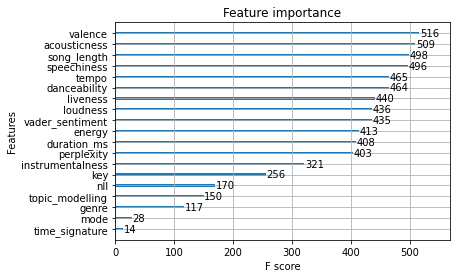

In [264]:
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(xgb)
pyplot.show()